# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential

In [2]:
sns.set_theme()

In [3]:
RANDOM_SEED = 12345
BATCH_SIZE = 32
TEST_SIZE = .25

## Исследовательский анализ данных

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


- Выборка довольно небольшая, всего 7591 фотография. Для предобученных сетей, в целом, должно быть достаточно
- Судя по всему (в том числе и подсказке) понадобится загрузчик flow_from_dataframe, так как есть соответствие данных столбца file_name из датасета labels.csv и имени файлов, которые будут использованы для обучения

In [7]:
q5, q50, q95 = np.quantile(labels.real_age, q=[.05, .5, .95])

In [8]:
q5, q95

(5.0, 63.0)

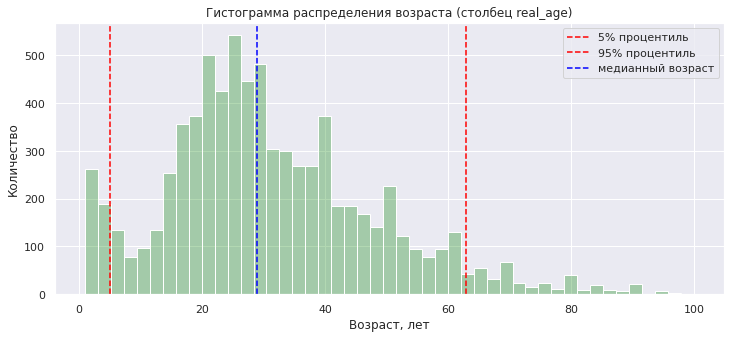

In [9]:
figure, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.histplot(
    data=labels,
    x='real_age',
    ax=ax,
    color='green',
    alpha=0.3
);

ax.axvline(x=q5, ymin=0, ymax=550, color='red', ls='--', label='5% процентиль')
ax.axvline(x=q95, ymin=0, ymax=550, color='red', ls='--', label='95% процентиль')
ax.axvline(x=q50, ymin=0, ymax=550, color='blue', ls='--', label='медианный возраст')

ax.legend()
ax.set_xlabel('Возраст, лет')
ax.set_ylabel('Количество')
ax.set_title('Гистограмма распределения возраста (столбец real_age)');

In [10]:
labels[['real_age']].describe().round(2)

,real_age
count,7591.00
mean,31.20
std,17.15
min,1.00
25%,20.00
50%,29.00
75%,41.00
max,100.00


In [11]:
labels.query('real_age < 18').describe()

,real_age
count,1503.000000
mean,9.988689
std,5.638866
min,1.000000
25%,5.000000
50%,11.000000
75%,15.000000
max,17.000000


In [12]:
tmp = labels.copy()
tmp['is_adult'] = tmp.real_age.apply(lambda x: 'Взрослый' if x >= 18 else 'Ребенок')

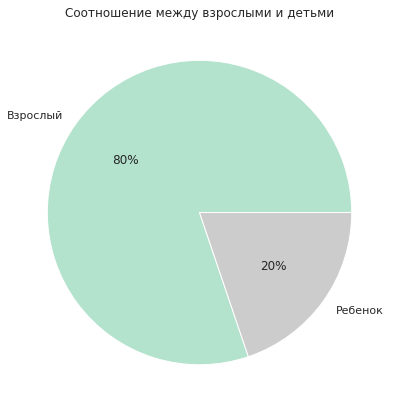

In [13]:
(tmp
 .is_adult
 .value_counts()
 .plot(
    kind='pie', 
    autopct = "%.0f%%",
    ylabel= "",
    figsize=(7,7),
    cmap='Pastel2',
    title='Соотношение между взрослыми и детьми'));

- Распределение немного похоже на нормальное, но есть заметные пики в детском возрасте и тяжелый хвост распределения в преклонных годах
- Медианный возраст людей в выборке - 29 лет
- 90 процентов людей в выборке находятся в возрасте от 5 до 63 лет
- Есть долгожители: в выборке присутствуют 100 летние люди
- Есть также любопытные пики, приходящиеся на возраст, кратный 5 годам.

In [14]:
datagen = ImageDataGenerator()

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='training',
    x_col='file_name',
    y_col='real_age',
    seed=RANDOM_SEED)

Found 7591 validated image filenames.


- train_datagen_flow - это итератор, в котором собраны данные о фотографиях и табличных данных, что очень удобно
- Посмотрим на 12 фотографий людей в этом наборе фотографий, предварительно приведенных к размеру 224 X 224

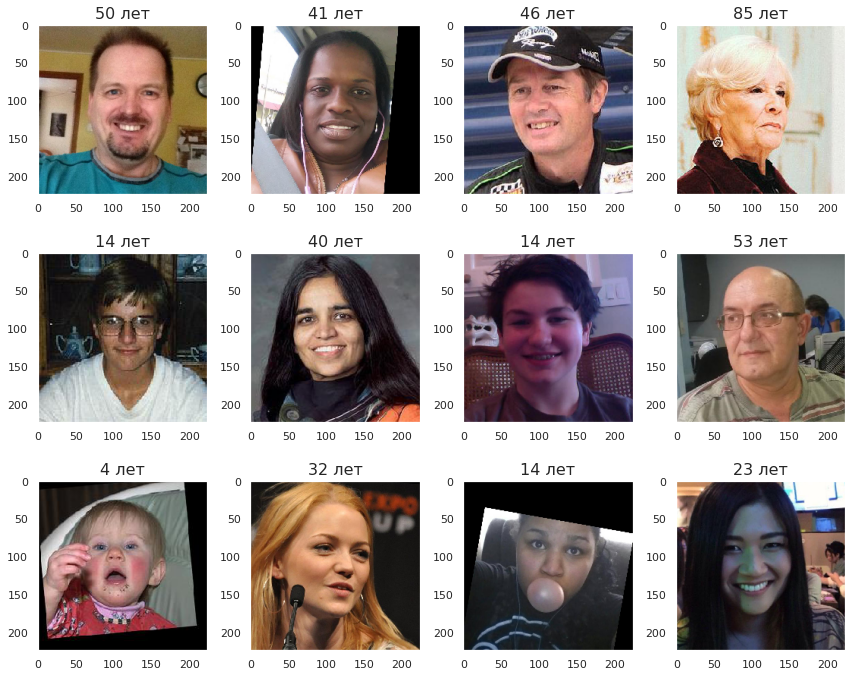

In [15]:
features, target = next(train_datagen_flow)

fig = plt.figure(figsize=(12,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i] / 255, cmap='gray')
    plt.title(f'{target[i]} лет', fontsize=16)
    plt.tight_layout()
    plt.grid(False)

- Видим, что в основном фото вертикальные, лица видны и возраст в выборке размечен приблизительно верно, здравый смысл присутствует
- Есть фото с поворотами и кусками черного фона
- На некоторых фотографиях присутствуют искажения (растянутый части фото)

## Обучение модели

```python

def load_train(path):

    datagen = ImageDataGenerator(
        rotation_range = 45,
        horizontal_flip = True,
        rescale=1./255,
        validation_split=.25
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return datagen_flow


def load_test(path):

    datagen = ImageDataGenerator(
        validation_split=TEST_SIZE,
        rescale=1./255)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        subset='validation',
        seed=12345
    )

    return datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='relu'))


    optimizer = Adam(lr=.0001)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])

    return model

def train_model(model, train_data,
                test_data,
                batch_size=None, epochs=15,
                steps_per_epoch=None,
                validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/15
2025-05-21 08:46:33.841573: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-21 08:46:34.718140: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 168s - loss: 210.3237 - mae: 10.7471 - val_loss: 453.2581 - val_mae: 16.2090
Epoch 2/15
178/178 - 121s - loss: 107.4198 - mae: 7.8795 - val_loss: 500.9618 - val_mae: 17.1805
Epoch 3/15
178/178 - 123s - loss: 87.4852 - mae: 7.1062 - val_loss: 354.2815 - val_mae: 13.9631
Epoch 4/15
178/178 - 122s - loss: 70.4170 - mae: 6.4137 - val_loss: 146.0976 - val_mae: 8.9285
Epoch 5/15
178/178 - 122s - loss: 60.5374 - mae: 5.9428 - val_loss: 90.7186 - val_mae: 7.2012
Epoch 6/15
178/178 - 121s - loss: 51.4783 - mae: 5.5254 - val_loss: 100.3824 - val_mae: 7.7904
Epoch 7/15
178/178 - 121s - loss: 42.9652 - mae: 5.0776 - val_loss: 94.4212 - val_mae: 7.4595
Epoch 8/15
178/178 - 122s - loss: 42.5496 - mae: 4.9669 - val_loss: 129.4397 - val_mae: 9.0318
Epoch 9/15
178/178 - 120s - loss: 37.0844 - mae: 4.6562 - val_loss: 78.2577 - val_mae: 6.7017
Epoch 10/15
178/178 - 121s - loss: 31.9133 - mae: 4.3493 - val_loss: 72.4722 - val_mae: 6.3330
Epoch 11/15
178/178 - 123s - loss: 31.2543 - mae: 4.2614 - val_loss: 93.5753 - val_mae: 7.4468
Epoch 12/15
178/178 - 120s - loss: 27.2872 - mae: 4.0243 - val_loss: 73.6700 - val_mae: 6.3910
Epoch 13/15
178/178 - 122s - loss: 24.5636 - mae: 3.7986 - val_loss: 74.6475 - val_mae: 6.4306
Epoch 14/15
178/178 - 121s - loss: 24.6564 - mae: 3.7782 - val_loss: 71.7617 - val_mae: 6.3507
Epoch 15/15
178/178 - 122s - loss: 23.0348 - mae: 3.6608 - val_loss: 92.7536 - val_mae: 7.3520
WARNING:tensorflow:sample_weight modes were coerced from
...
to
['...']
60/60 - 12s - loss: 92.7536 - mae: 7.3520
```

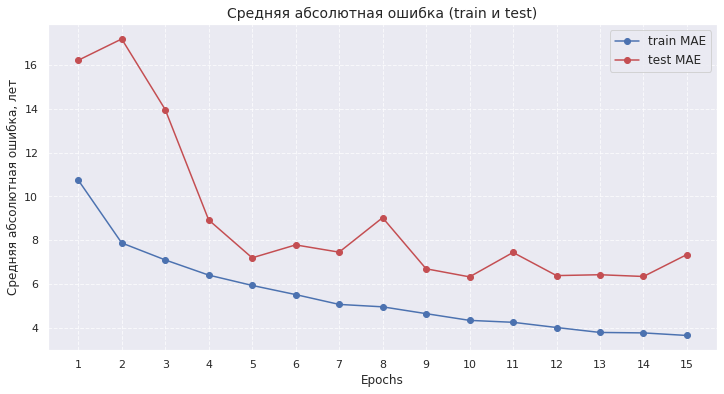

In [16]:
epochs = range(1, 16)
train_mae = [10.7471, 7.8795, 7.1062, 6.4137, 5.9428, 5.5254, 5.0776, 
             4.9669, 4.6562, 4.3493, 4.2614, 4.0243, 3.7986, 3.7782, 3.6608]
val_mae = [16.2090, 17.1805, 13.9631, 8.9285, 7.2012, 7.7904, 7.4595, 
           9.0318, 6.7017, 6.3330, 7.4468, 6.3910, 6.4306, 6.3507, 7.3520]

plt.figure(figsize=(12, 6))

plt.plot(epochs, train_mae, 'bo-', label='train MAE')
plt.plot(epochs, val_mae, 'ro-', label='test MAE')

plt.title('Средняя абсолютная ошибка (train и test)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Средняя абсолютная ошибка, лет', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs)

plt.show()

## Анализ обученной модели

- Видим, что ошибка на трейне падала монотонно, без сильных пульсаций. Для того чтобы избежать переобучения, в модель был добавлен слой случайного отключения нейронов
- На тестовых данных ошибка уменьшалась скачкообразно. Однако тенденция на снижение все равно прослеживается.
- В итоге, в абсолютных величинах модель ошибается в среднем на 7.35 лет. Довольно критично в контексте продажи алкоголя, однако для предложения категорий товаров в заданном возрастном сегменте модель подходит неплохо.
- Возможно, проблема в датасете. Средний возраст клиентов - 29 лет. В контексте продажи алкоголя большинство клиентов - подходящий сегмент. Но дети представлены в выборке не очень репрезентативно (их в 4 раза меньше).
- Стоит сбалансировать датасет с точки зрения признака "ребенок/взрослый"